## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Ергалиев Аслан Галымжанович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 305kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.33MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.06MB/s]


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

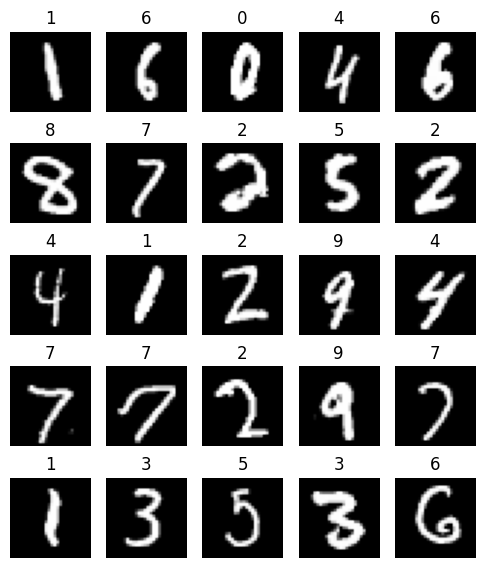

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

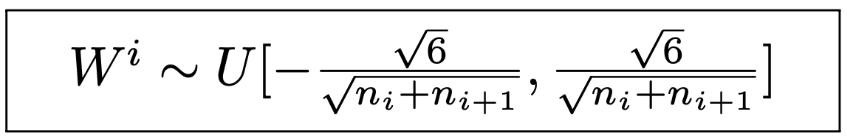

In [18]:
import math


def init_layer_xavier(layer):
    n_in = layer.in_features
    n_out = layer.out_features
    std = math.sqrt(2.0 / (n_in + n_out))
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(0.0, std)


layer_1 = nn.Linear(28*28, 256)
layer_2 = nn.Linear(256, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_xavier(layer_1)
init_layer_xavier(layer_2)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

In [19]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

loss = loss_fn(activations, y)
loss.backward()

Forward std: 0.976319
Forward std: 0.666016
Backward grad std: 0.024944
Backward grad std: 0.016772


C:\Users\aslan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

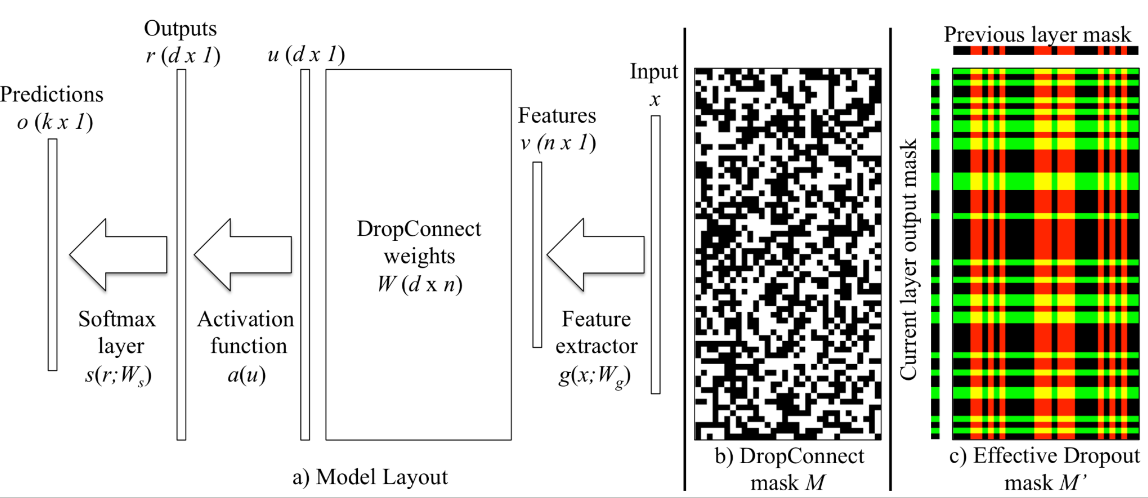

In [20]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.ones_like(self.linear.weight) * (1 - self.p))
            mask.requires_grad = False
        else:
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [21]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [22]:
layers = [
    DropConnect(7 * 7 * 4, 128, p=0.3),
    nn.ReLU(),
    DropConnect(128, 10, p=0.3)
]

In [23]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [24]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303017
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.032103
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.529871
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.514032
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.425229
Test Epoch: 0	Loss: 0.310044
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.298618
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.275982
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.220844
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.217396
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.394866
Test Epoch: 1	Loss: 0.234428
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.238702
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.229056
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.204399
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.248202
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.148573
Test Epoch: 2	Loss: 0.186275
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.184205
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.116732
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.174489
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [25]:
layers_dropout = nn.Sequential(
    nn.Linear(7*7*4, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)
network_dropout = TestNetwork(layers_dropout)

In [26]:
layers_dropconnect = nn.Sequential(
    DropConnect(7*7*4, 128, p=0.3),
    nn.ReLU(),
    DropConnect(128, 128, p=0.3),
    nn.ReLU(),
    DropConnect(128, 10, p=0.3)
)
network_dropconnect = TestNetwork(layers_dropconnect)

In [27]:
def train_network(network, optimizer, loss_fn, train_loader, test_loader, epochs=10):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        network.train()
        batch_losses = []
        for X, y in train_loader:
            optimizer.zero_grad()
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))

        network.eval()
        test_batch_losses = []
        with torch.no_grad():
            for X, y in test_loader:
                output = network(X)
                loss = loss_fn(output, y)
                test_batch_losses.append(loss.item())
        test_losses.append(np.mean(test_batch_losses))

        print(f"Epoch {epoch+1}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    return train_losses, test_losses

In [28]:
loss_fn = nn.NLLLoss()

optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)


In [29]:
print("=== Обучение Dropout ===")
train_do, test_do = train_network(network_dropout, optimizer_dropout, loss_fn, train_loader, test_loader)


=== Обучение Dropout ===
Epoch 1: train_loss=0.5649, test_loss=0.1477
Epoch 2: train_loss=0.1890, test_loss=0.1058
Epoch 3: train_loss=0.1483, test_loss=0.0891
Epoch 4: train_loss=0.1228, test_loss=0.0721
Epoch 5: train_loss=0.1097, test_loss=0.0687
Epoch 6: train_loss=0.0995, test_loss=0.0641
Epoch 7: train_loss=0.0943, test_loss=0.0657
Epoch 8: train_loss=0.0882, test_loss=0.0580
Epoch 9: train_loss=0.0832, test_loss=0.0669
Epoch 10: train_loss=0.0800, test_loss=0.0589


In [30]:
print("\nОбучение DropConnect")
train_dc, test_dc = train_network(network_dropconnect, optimizer_dropconnect, loss_fn, train_loader, test_loader)



Обучение DropConnect
Epoch 1: train_loss=0.8476, test_loss=0.3952
Epoch 2: train_loss=0.2688, test_loss=0.2191
Epoch 3: train_loss=0.1900, test_loss=0.1840
Epoch 4: train_loss=0.1548, test_loss=0.1725
Epoch 5: train_loss=0.1326, test_loss=0.1393
Epoch 6: train_loss=0.1188, test_loss=0.1323
Epoch 7: train_loss=0.1091, test_loss=0.1203
Epoch 8: train_loss=0.1031, test_loss=0.1086
Epoch 9: train_loss=0.0922, test_loss=0.0971
Epoch 10: train_loss=0.0886, test_loss=0.0989


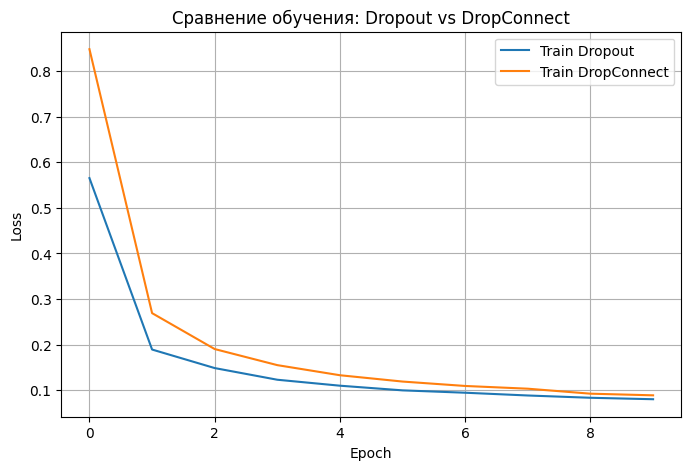

In [32]:
plt.figure(figsize=(8,5))
plt.plot(train_do, label='Train Dropout')
plt.plot(train_dc, label='Train DropConnect')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Сравнение обучения: Dropout vs DropConnect')
plt.legend()
plt.grid(True)
plt.show()

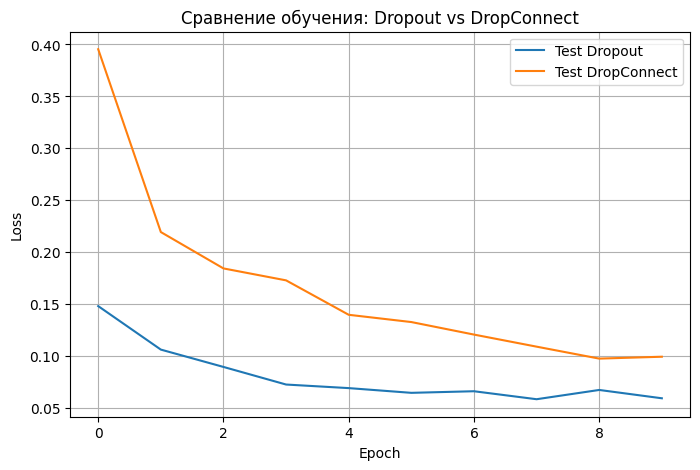

In [33]:
plt.figure(figsize=(8,5))
plt.plot(test_do, label='Test Dropout')
plt.plot(test_dc, label='Test DropConnect')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Сравнение обучения: Dropout vs DropConnect')
plt.legend()
plt.grid(True)
plt.show()  

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

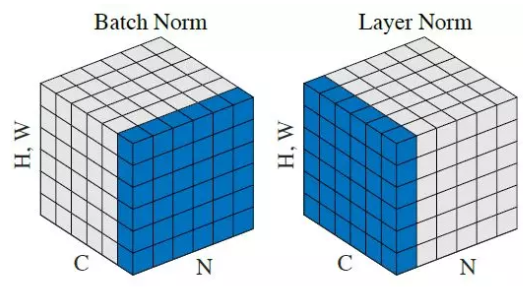

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [34]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)

        output = (x - mean) / (std + self.eps)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [35]:
layers_batchnorm = nn.Sequential(
    nn.Linear(7*7*4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
network_bn = TestNetwork(layers_batchnorm)

In [36]:
layers_layernorm = nn.Sequential(
    nn.Linear(7*7*4, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
network_ln = TestNetwork(layers_layernorm)

In [37]:
loss_fn = nn.NLLLoss()

optimizer_bn = torch.optim.Adam(network_bn.parameters(), lr=0.001)
optimizer_ln = torch.optim.Adam(network_ln.parameters(), lr=0.001)

In [38]:
print("Обучение BatchNorm")
train_bn, test_bn = train_network(network_bn, optimizer_bn, loss_fn, train_loader, test_loader)


Обучение BatchNorm
Epoch 1: train_loss=0.2459, test_loss=0.1030
Epoch 2: train_loss=0.0800, test_loss=0.0967
Epoch 3: train_loss=0.0597, test_loss=0.0686
Epoch 4: train_loss=0.0502, test_loss=0.0611
Epoch 5: train_loss=0.0411, test_loss=0.0559
Epoch 6: train_loss=0.0362, test_loss=0.0527
Epoch 7: train_loss=0.0306, test_loss=0.0506
Epoch 8: train_loss=0.0268, test_loss=0.0502
Epoch 9: train_loss=0.0237, test_loss=0.0564
Epoch 10: train_loss=0.0225, test_loss=0.0610


In [39]:
print("\nОбучение LayerNorm")
train_ln, test_ln = train_network(network_ln, optimizer_ln, loss_fn, train_loader, test_loader)


Обучение LayerNorm
Epoch 1: train_loss=1.9080, test_loss=1.3642
Epoch 2: train_loss=1.0759, test_loss=0.8534
Epoch 3: train_loss=0.7107, test_loss=0.5952
Epoch 4: train_loss=0.5455, test_loss=0.4880
Epoch 5: train_loss=0.4567, test_loss=0.4129
Epoch 6: train_loss=0.3900, test_loss=0.3543
Epoch 7: train_loss=0.3375, test_loss=0.3134
Epoch 8: train_loss=0.2958, test_loss=0.2721
Epoch 9: train_loss=0.2627, test_loss=0.2487
Epoch 10: train_loss=0.2371, test_loss=0.2212


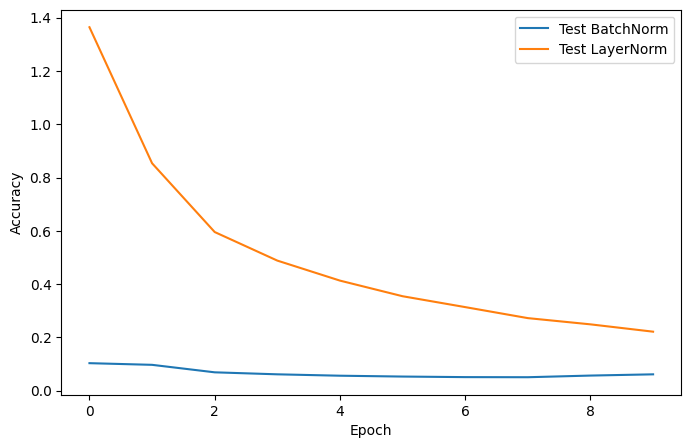

In [40]:
plt.figure(figsize=(8,5))
plt.plot(test_bn, label='Test BatchNorm')
plt.plot(test_ln, label='Test LayerNorm')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

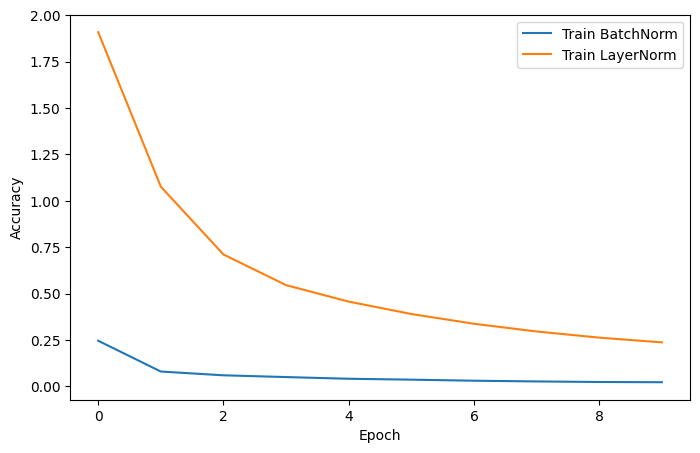

In [41]:
plt.figure(figsize=(8,5))
plt.plot(train_bn, label='Train BatchNorm')
plt.plot(train_ln, label='Train LayerNorm')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()